In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install scanpy
!pip install pillow --upgrade
!pip install python-igraph
!pip install graspologic
!pip install networkx
!pip install matplotlib
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install torch-scatter==latest+cu101 torch-sparse==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.7.0.html
!pip install torch_geometric
!pip install captum

     |████████████████████████████████| 7.7MB 13.5MB/s 
     |████████████████████████████████| 122kB 49.2MB/s 
     |████████████████████████████████| 71kB 7.1MB/s 
     |████████████████████████████████| 51kB 6.0MB/s 
  Created wheel for sinfo: filename=sinfo-0.3.1-cp36-none-any.whl size=7018 sha256=fdfd4b66526cfa1b88cef2f74ee8d35731a1b50f21de33048632d510c3f906fb
  Stored in directory: /root/.cache/pip/wheels/11/f0/23/347d6d8e59787c2bc272162d18223dc3b45bd6dc40aceee6af
Successfully built sinfo
     |████████████████████████████████| 2.2MB 11.2MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


     |████████████████████████████████| 3.2MB 10.9MB/s 
     |████████████████████████████████| 5.1MB 11.9MB/s 
     |████████████████████████████████| 51kB 5.3MB/s 
     |████████████████████████████████| 24.2MB 1.9MB/s 
     |████████████████████████████████| 942kB 45.2MB/s 
     |████████████████████████████████| 430kB 57.5MB/s 
  Created wheel for graspologic: filename=graspologic-0.1.0.dev465176579-cp36-none-any.whl size=5137232 sha256=9973bab71870bb9dc6bf1fa061a523a2fe136132d8da05d11804f50cbfb9ff4a
  Stored in directory: /root/.cache/pip/wheels/7a/0e/59/47b7c672b6d04471b3e70442cce9f18c240076cd60785951e4
  Created wheel for hyppo: filename=hyppo-0.1.3-cp36-none-any.whl size=64216 sha256=7ca5366d24532873ef55f651940016f711f6d43dde658bc0b4cdda13aad1da6a
  Stored in directory: /root/.cache/pip/wheels/c0/ad/6b/e2bf22a0f13f40c1bc10ba65e8b5cf1b3dc4cf9aeb80331650
Successfully built graspologic hyppo
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfu

In [ ]:
!wget https://gitlab.com/cvejic-group/integrative-scrna-scatac-human-foetal/-/raw/master/Data/ScanpyObjets/MergedAllSamples_annotated.h5ad
!wget ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_36/gencode.v36.chr_patch_hapl_scaff.annotation.gtf.gz
!gunzip gencode.v36.chr_patch_hapl_scaff.annotation.gtf.gz

--2021-01-07 08:35:42--  https://gitlab.com/cvejic-group/integrative-scrna-scatac-human-foetal/-/raw/master/Data/ScanpyObjets/MergedAllSamples_annotated.h5ad
Resolving gitlab.com (gitlab.com)... 172.65.251.78, 2606:4700:90:0:f22e:fbec:5bed:a9b9
Connecting to gitlab.com (gitlab.com)|172.65.251.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 419106712 (400M) [application/octet-stream]
Saving to: ‘MergedAllSamples_annotated.h5ad.1’

MergedAllSamples_an 100%[===================>] 399.69M   166MB/s    in 2.4s    

2021-01-07 08:35:48 (166 MB/s) - ‘MergedAllSamples_annotated.h5ad.1’ saved [419106712/419106712]

--2021-01-07 08:35:48--  ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_36/gencode.v36.chr_patch_hapl_scaff.annotation.gtf.gz
           => ‘gencode.v36.chr_patch_hapl_scaff.annotation.gtf.gz’
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.197.74
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.197.74|:21... connected.
Logging in as a

In [1]:
!cp -r drive/MyDrive/epiClassify .
%cd epiClassify

/content/epiClassify


In [2]:
from GNNProject.utils import *
from GNNProject.dataset import *
from GNNProject.model import *
from GNNProject.classifier import *
from captum import *
from captum.attr import IntegratedGradients
import scanpy
import pandas as pd
import igraph as ig

In [3]:
import torch
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev)
print(device)

cpu


In [38]:
gencode = pd.read_table("gencode.v36.chr_patch_hapl_scaff.annotation.gtf", comment="#", sep = "\t"\
  , names = ['seqname', 'source', 'feature', 'start' , 'end', 'score', 'strand', 'frame', 'attribute'])
adata = scanpy.read('MergedAllSamples_annotated.h5ad')
adata.obs['annotation'] = adata.obs['annotation']

/usr/local/lib/python3.6/dist-packages/anndata/compat/__init__.py:182: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/anndata/compat/__init__.py:182: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


In [40]:
fine_types  = adata.obs['manual_annotation'].tolist()
broad_types = ['Monocyte', 'Comm', 'Dend', 'Endothelial', 'Erythroid',\
               'Granulocyte', 'MPP', 'Mast', 'B cell', 'Prog']

for bt in broad_types:
   idx = [i for i, item in enumerate(fine_types) if re.search('.*{}.*'.format(bt), item)]
   for i in idx:
    fine_types[i] = bt
   
adata.obs['manual_annotation'] = fine_types
adata = adata[adata.obs['manual_annotation'] != 'Unspecified']

gencode = gencode.loc[gencode.seqname == 'chr12']

In [41]:
# indices = [gencode[id in gencode['attribute']].index.tolist()[0] for id in ]
import re

gencode = gencode.sort_values(by=['seqname', 'start'])

ids = [re.search('gene_id \"(.+?)\"', x).group(1) for x in gencode['attribute']]
ids = [re.sub('\\..*', '', id) for id in ids]
ids = list(set(ids))
inter = list(set(ids) & set(adata.var['Ensembl']))  
adata = adata[:, adata.var['Ensembl'].isin(inter)]
ind = [ids.index(id) for id in adata.var['Ensembl']]
ind = [sorted(ind).index(x) for x in ind]
del gencode
del ids
del inter

In [42]:
adata = adata[:, ind]
# adata = adata[:, 1:5000]
n_features = adata.shape[1]
print(n_features)
n_classes  = len(set(adata.obs['manual_annotation']))
print(n_classes)

1576
11


In [43]:
import igraph as ig
g = ig.Graph()
edges = [(i, i+1) for i in range(n_features-1)]
g.add_vertices(n_features)
g.add_edges(edges)
adj = np.array(g.get_adjacency().data)
# adj_test  = np.array(g.get_adjacency().data)

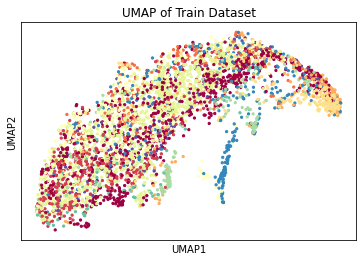

In [44]:
dataset = Dataset(tag='real_scanpy', random_seed=1996)
dataset.X_train = adata.layers['counts']
y = pd.get_dummies(adata.obs['manual_annotation'])
dataset.y_train = y.values.argmax(1)
dataset.A_train = adj
# dataloaders with true graphs
train_true = dataset._dataloader('train', use_true_graph=True,batch_size=16)
# test_true  = dataset._dataloader('test',use_true_graph=True,batch_size=16)
# plot dataframe
plot_lowDim(dataset.X_train, dataset.y_train, title='UMAP of Train Dataset')
plt.show()

In [47]:
# NN params
epochs   = 30
lr       = 0.001
momentum = .9

In [49]:
clf_ConvNet = Classifier(
        n_features=n_features,
        n_classes=n_classes,
        n_hidden_GNN=[10],
        n_hidden_FC=[],
        K = 3,
        pool_K=3,
        dropout_FC=0.2,
        dropout_GNN=0.3,
        classifier='Conv1d', 
        lr=lr,
        momentum=momentum,
        log_dir="runs/ConvNet_true",
        device = device) 
# fit the classifier on train data
clf_ConvNet.fit(train_true, epochs = epochs, test_dataloader=None,verbose=True)
# evaluate the trained classifier on train data
_ = clf_ConvNet.eval(train_true, verbose=True)

[1] loss: 2.389


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[4] loss: 0.799
[7] loss: 0.633
[10] loss: 0.591
[13] loss: 0.535
[16] loss: 0.509
[19] loss: 0.481
[22] loss: 0.445
[25] loss: 0.438
[28] loss: 0.435
Accuracy: 0.905
Confusion Matrix:
 [[ 733    0    0    0   17    1    5    0    0    0    0]
 [   0  429    0    0    2    2   14    0    0    0    0]
 [   0    0  172    0    5    0    0    0    0    0    0]
 [  21    0    3   69  147    0    7    0    0    4    0]
 [   1    0    0    0  253    0    0    0    0    0    0]
 [   1    0    0    0   10  416   15    0    0    0    0]
 [   4    3    0    0    5   10 1149    0    0    0    0]
 [   0    5    0    0   11    6    1  177    0    0    0]
 [   0    3    0    0    5    0    1    0   87    0    0]
 [   0    0    4    0   35    5    1    0    0  267    0]
 [   1    8    2    0    9    6   26    0    0    0  104]]
Precision: 0.934
Recall: 0.905
f1_score: 0.900


In [56]:
import numpy as np
clf_ConvNet.net.eval()
importances = np.zeros((n_features, n_classes))
for batch in train_true:
  e = batch.edge_index.to(device)
  input = batch.x.to(device)
  target = batch.y.to(device)
  ig = IntegratedGradients(clf_ConvNet.net)
  attributions = ig.attribute(input, target=target, additional_forward_args=(e,))
  attributions = attributions.to('cpu').detach().numpy()
  importances[:, target.to('cpu').numpy()] += attributions
idx = (-np.absolute(importances)).argsort(axis=0)
# idx = (-importances).argsort(axis=0)

In [57]:
markers = dict()

for cl in range(n_classes):
  classes = y.columns
  markers[classes[cl]] = adata.var_names[idx[0:15, cl]].tolist()

markers = pd.DataFrame.from_dict(markers)

In [60]:
markers.to_csv(r'test_resuslts_v2.txt', sep='\t')

In [58]:
markers

,B cell,Comm,Dend,Endothelial,Erythroid,Granulocyte,MPP,Mast,Megakaryocytes,Monocyte,Prog
0,DTX1,TESPA1,ZDHHC17,MYL6,SLC25A3,LYZ,RPL14P1,TESPA1,CLEC1B,LYZ,HMGA2
1,MLXIP (ENSG00000175727),PLXNC1,SLC15A4,RPL41,RPL41,MGST1,HMGA2,CD63,CMAS,PLBD1,MLF2
2,CD9,SCARB1,PCED1B-AS1,RPS26,DYNLL1,TUBA1A,TAOK3,ATP6V0A2,PRICKLE1,LRRK2,BCAT1
3,SLC38A1,ATP6V0A2,SCAF11,RPL6,ARHGDIB,SNRPF,RIMKLB,RNF10,SLC2A3,SLC2A3,NEMP1
4,SCARB1,BCAT1,CORO1C,HSP90B1,RPL18AP3,ERP29,NFE2,SLC2A3,NINJ2,ALDH2,KNTC1
5,CLEC2D,PPM1H,C12orf75,ATP5F1B,MYL6,NFE2,RPS2P5,ESYT1,PPP1R12A,ZNF385A,RAP1B
6,SRSF9,CDK4,CLEC4C,NFE2,RAN,GIHCG (ENSG00000257698),AC005912.1,PPM1H,CHFR,HNRNPA1,NCAPD2
7,RIMKLB,MGST1,SELPLG,LDHB,UBC,GNPTAB,BCAT1,RPS2P5,ATP6V0A2,ATP5F1B,PCBP2
8,YBX3,METAP2,MLF2,SLC25A3,WNK1,TNFRSF1A,ARHGAP9,TUBA1A,VPS29,CKAP4,DENR
9,BCL7A (ENSG00000110987),CMAS,ULK1,ELK3,SLC11A2,SELPLG,RPL41P5,CHD4,MLEC,BTG1,TROAP
